In [3]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os

In [37]:
import importlib 
import src.var_net as var_net
import src.linear_var_hypernet as linear_var_hypernet
import src.base_net  as base_net
import src.utils as utils
importlib.reload(var_net)
importlib.reload(linear_var_hypernet)
importlib.reload(base_net)
importlib.reload(utils)



<module 'src.utils' from '/home/legin/reps/VarHyperNet/code/src/utils.py'>

In [5]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [20]:
batch_size = 256
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 10 #количество эпох
hidden_num = 100 # количество нейронов на скрытом слое
lamb = [0.01, 0.1, 1,  10, 100]
start_num = 3

lambda_encode = t.log
lambda_sample_num = 5
path_to_save = 'saved_mnist_lr'

if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

In [7]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)

def test_acc(net): # точность классификации
    acc = []    
    correct = 0
    net.eval()
    for x,y in test_loader: 
        x = x.to(device)
        y = y.to(device)  
        out = net(x)    
        correct += out.argmax(1).eq(y).sum().cpu().numpy()
    acc = (correct / len(test_data))

    return acc




In [8]:
def train_batches(net, loss_fn, optimizer, lam, label):
    tq = tqdm.tqdm(train_loader)
    losses = []
    for x,y in tq:            
        x = x.to(device)
        y = y.to(device)          
        optimizer.zero_grad()  
        loss = 0
        if lam is None:
            for _ in range(lambda_sample_num):  
                p = t.rand(1).to(device)*4 -2
                lam_param = 10**p[0]                
                #t.rand(1).to(device)[0]*100.0                  
                out = net(x, lambda_encode(lam_param))
                loss = loss + loss_fn(out, y)/lambda_sample_num
                loss += net.KLD(lambda_encode(lam_param))*lam_param/len(train_data)/lambda_sample_num
                losses+=[loss.cpu().detach().numpy()]
            # правдоподобие должно суммироваться по всей обучающей выборке
            # в случае батчей - она приводится к тому же порядку 
        else:
            out = net(x)
            loss = loss + loss_fn(out, y)
            loss += net.KLD()*lam/len(train_data)
            losses+=[loss.cpu().detach().numpy()]
        tq.set_description(label+str(np.mean(losses)))
        loss.backward()       
        clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
        optimizer.step()

In [26]:
t.manual_seed(0)
for lam in lamb:
    for start in range(start_num):                    
            net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                          act=lambda x:x))
            
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'lambda {}, epoch {}: '.format(lam, e)                
                train_batches(net, loss_fn, optim, lam, label)
            t.save(net.state_dict(), os.path.join(path_to_save, 'var_net_lam_{}_start_{}.cpk'.format(lam, start)))

lambda 10, epoch 8: 27.261803: 100%|██████████| 235/235 [00:09<00:00, 25.05it/s]


lambda 100, epoch 9: 196.24771: 100%|██████████| 235/235 [00:09<00:00, 25.78it/s]


In [38]:
t.manual_seed(0)
for lam in lamb:
    for start in range(start_num):                    
            net = var_net.VarNet(base_net.BaseLayer(784,  hidden_num, device), 
                     base_net.BaseLayer(hidden_num, 10, device,
                              act=lambda x:x))
            
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'lambda {}, epoch {}: '.format(lam, e)                
                train_batches(net, loss_fn, optim, lam, label)
            t.save(net.state_dict(), os.path.join(path_to_save, 'base_net_lam_{}_start_{}.cpk'.format(lam, start)))

/home/legin/reps/VarHyperNet/code/src/base_net.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
lambda 10, epoch 5: 0.22358502: 100%|██████████| 235/235 [00:08<00:00, 26.77it/s]


lambda 100, epoch 9: 0.33946034: 100%|██████████| 235/235 [00:08<00:00, 26.94it/s]


In [28]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                          act=lambda x:x)).to(device)

lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        net.load_state_dict(t.load(os.path.join(path_to_save, 'var_net_lam_{}_start_{}.cpk'.format(lam, s))))
        lam_results[lam].append(utils.delete_10(net, device, lambda:test_acc(net), layer_num=2))
import json
with open(os.path.join(path_to_save, 'results_var.json'),'w') as out:
    out.write(json.dumps(lam_results))        

0.01 0
0.01 1
0.01 2
0.1 0
0.1 1
0.1 2
1 0
1 1
1 2
10 0
10 1
10 2
100 0
100 1
100 2


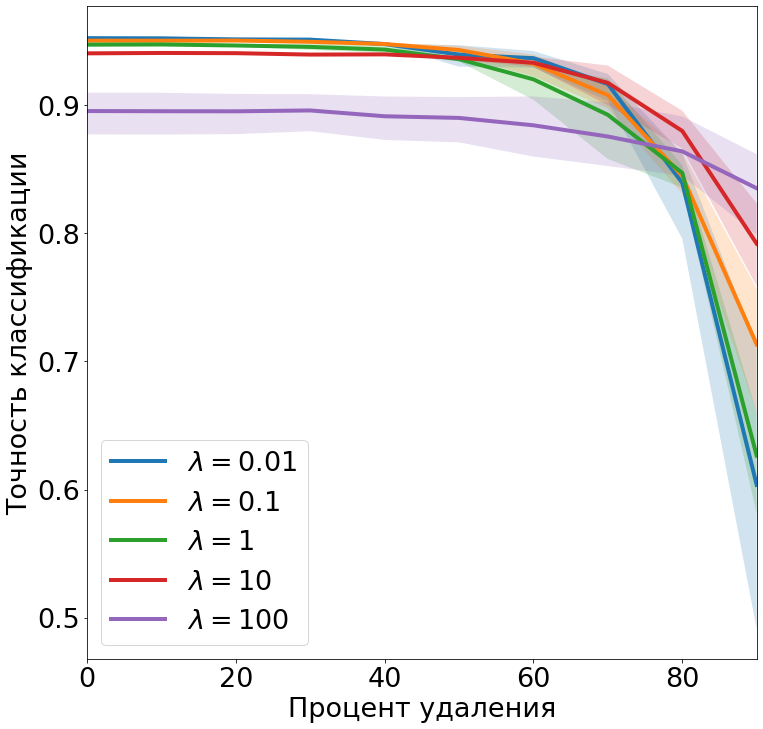

In [29]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()


In [39]:
net = var_net.VarNet(base_net.BaseLayer(784,  hidden_num, device), 
                     base_net.BaseLayer(hidden_num, 10, device,
                              act=lambda x:x)).to(device)               
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        net.load_state_dict(t.load(os.path.join(path_to_save, 'base_net_lam_{}_start_{}.cpk'.format(lam, s))))
        lam_results[lam].append(utils.delete_10(net, device, lambda:test_acc(net), layer_num=2, mode='base'))
import json
with open(os.path.join(path_to_save, 'results_base.json'),'w') as out:
    out.write(json.dumps(lam_results))        

0.01 0
0.01 1
0.01 2
0.1 0
0.1 1
0.1 2
1 0
1 1
1 2
10 0
10 1
10 2
100 0
100 1
100 2


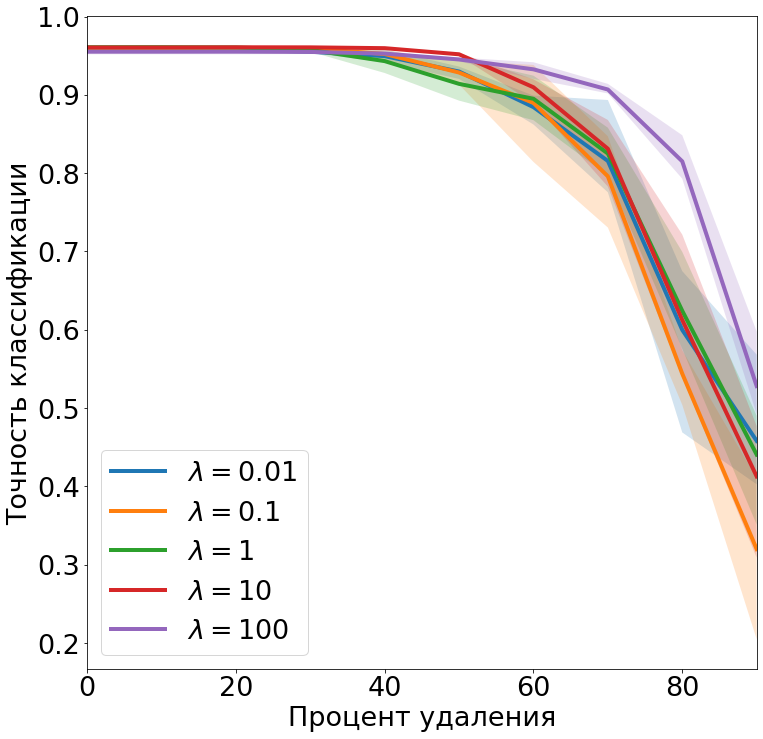

In [40]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()


In [41]:
t.manual_seed(0)
for start in range(start_num):         
    net = var_net.VarNet(linear_var_hypernet.VarLayerLinearAppr(784,  hidden_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
                         linear_var_hypernet.VarLayerLinearAppr(hidden_num, 10,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))
    net = net.to(device)
    optim = t.optim.Adam(net.parameters(), lr=5e-4)
    loss_fn = nn.CrossEntropyLoss().to(device)            
    for e in range(epoch_num):
        label = 'linear, epoch {}: '.format(e)                
        train_batches(net, loss_fn, optim, None, label)
    t.save(net.state_dict(), os.path.join(path_to_save, 'linear_start_{}.cpk'.format( start)))

/home/legin/reps/VarHyperNet/code/src/linear_var_hypernet.py:74: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  init_const)
/home/legin/reps/VarHyperNet/code/src/linear_var_hypernet.py:76: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  init_const2)
linear, epoch 9: 7.8761287: 100%|██████████| 235/235 [00:13<00:00, 17.45it/s]


In [42]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                                 var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x)).to(device)    
hnet = var_net.VarNet(linear_var_hypernet.VarLayerLinearAppr(784,  hidden_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
                         linear_var_hypernet.VarLayerLinearAppr(hidden_num, 10,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma)).to(device)    

lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'linear_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam))
        lam_results[lam].append(utils.delete_10(net, device, lambda:test_acc(net)))
import json
with open(os.path.join(path_to_save, 'results_linear.json'),'w') as out:
    out.write(json.dumps(lam_results))        

/home/legin/reps/VarHyperNet/code/src/var_net.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)


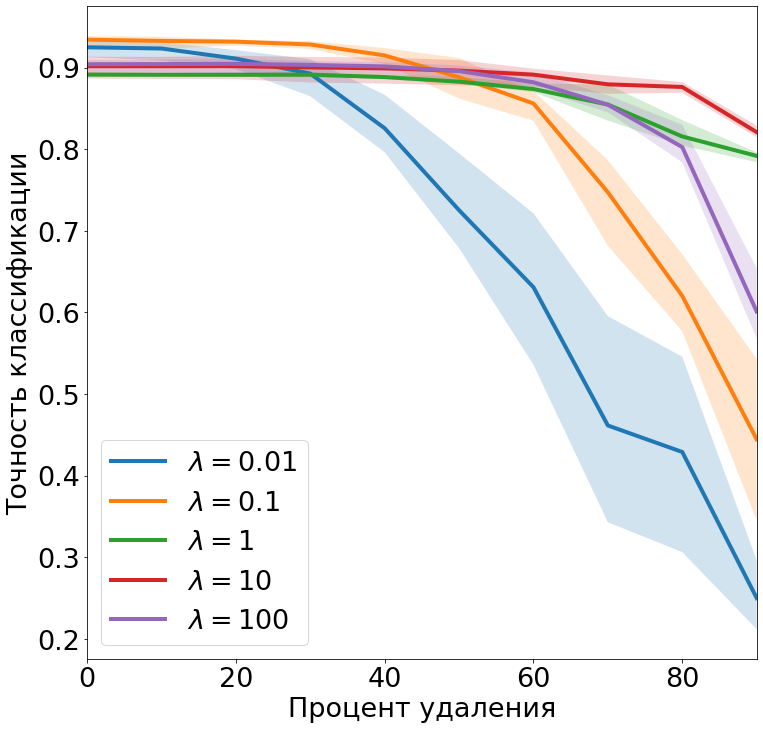

In [43]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()


In [47]:
t.manual_seed(0)
for start in range(start_num):         
    net = var_net.VarNet(base_net.BaseLayerLinear(784,  hidden_num),
                         base_net.BaseLayerLinear(hidden_num, 10,  act=lambda x:x))
    net = net.to(device)
    optim = t.optim.Adam(net.parameters(), lr=5e-4)
    loss_fn = nn.CrossEntropyLoss().to(device)            
    for e in range(epoch_num):
        label = 'linear, epoch {}: '.format(e)                
        train_batches(net, loss_fn, optim, None, label)
    t.save(net.state_dict(), os.path.join(path_to_save, 'linear_base_start_{}.cpk'.format( start)))

/home/legin/reps/VarHyperNet/code/src/linear_var_hypernet.py:74: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  init_const)
/home/legin/reps/VarHyperNet/code/src/linear_var_hypernet.py:76: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  init_const2)
linear, epoch 9: 0.4170509: 100%|██████████| 235/235 [00:10<00:00, 22.24it/s] 


In [50]:
net = net = var_net.VarNet(base_net.BaseLayer(784,  hidden_num, device), 
                     base_net.BaseLayer(hidden_num, 10, device,
                              act=lambda x:x)).to(device) 

hnet = var_net.VarNet(base_net.BaseLayerLinear(784,  hidden_num),
                         base_net.BaseLayerLinear(hidden_num, 10,  act=lambda x:x)).to(device)  

lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'linear_base_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam), mode='base')
        lam_results[lam].append(utils.delete_10(net, device, lambda:test_acc(net), mode='base'))
import json
with open(os.path.join(path_to_save, 'results_base_linear.json'),'w') as out:
    out.write(json.dumps(lam_results))        

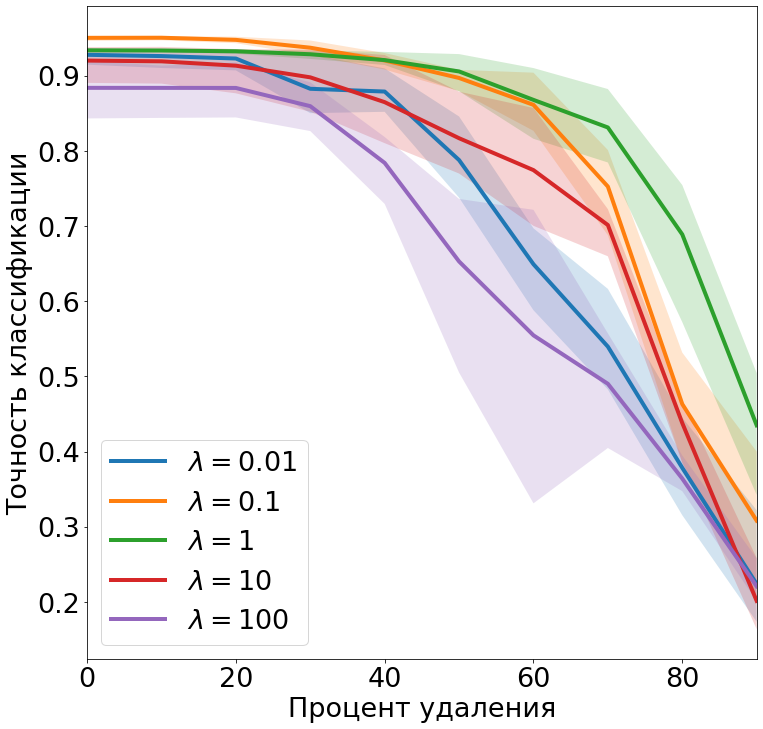

In [51]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()


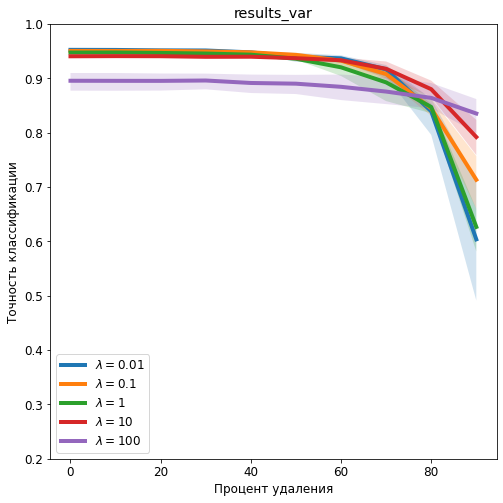

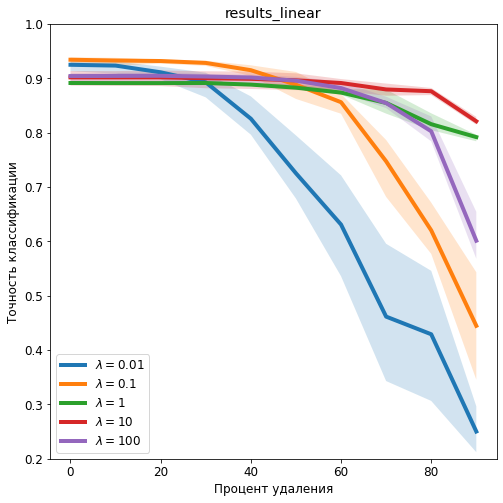

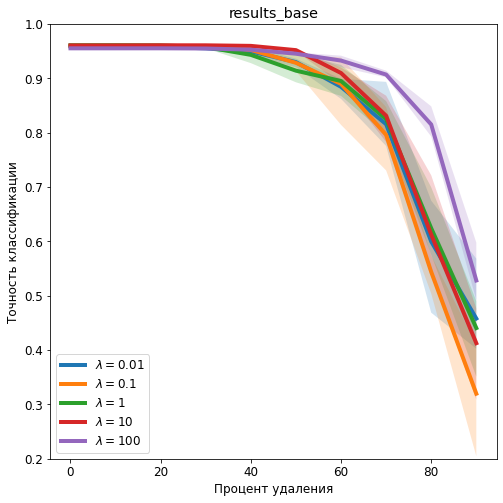

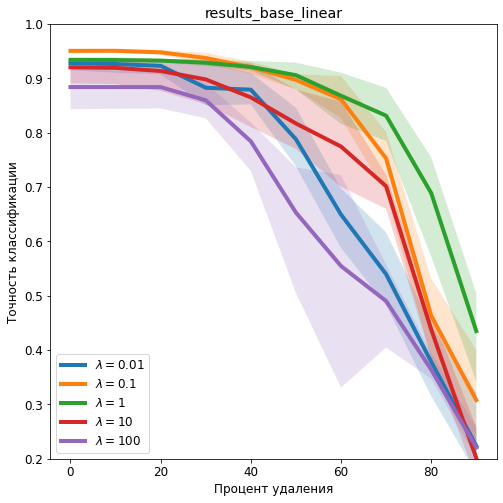

In [52]:
for mode in ['results_var', 'results_linear', 'results_base', 'results_base_linear']:    
    with open(os.path.join(path_to_save, mode+'.json')) as inp:
        lam_results = json.loads(inp.read())
    proc = [0,10,20,30,40,50,60,70,80,90]
    plt.rcParams['figure.figsize'] = 8, 8
    plt.rcParams.update({'font.size': 12})
    plt.rc('lines', linewidth=4)
    plt.title(mode)

    for lam in lamb:
        lam = str(lam)
        plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
        plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
    plt.ylabel('Точность классификации', fontsize = 12)
    plt.xlabel('Процент удаления', fontsize = 12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(loc='lower left')
    plt.ylim(0.2, 1.0)
    plt.show()
    

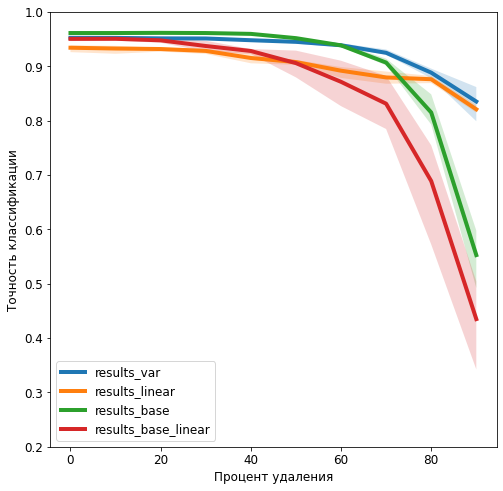

In [68]:
# Этот график - по сути упрощенная таблица: бежим по всем лямбдам и 
# выбираем наилучший результат для фиксированного процента удаленных параметров
# для var и base - результат совпадает с таблицей
# для linear и linear_base - в таблице мы бежим с шагом, а на графике просто перебираем наши лямбды

# из графика видно, что 
# 1. линейная аппроксимация работает нормально. 
# 2. вар сеть бьет base-сеть
# 3. возможно стоит заакцентировать внимани на 90-99% удаленных параметров,
# т.к. ближе к концу начинается самое интересное
for mode in ['results_var', 'results_linear', 'results_base', 'results_base_linear']:    
    with open(os.path.join(path_to_save, mode+'.json')) as inp:
        lam_results = json.loads(inp.read())
    proc = [0,10,20,30,40,50,60,70,80,90]
    plt.rcParams['figure.figsize'] = 8, 8
    plt.rcParams.update({'font.size': 12})
    plt.rc('lines', linewidth=4)    
    arr = np.array(list(lam_results.values()))
    arr = np.moveaxis(arr, [0], [1])
    best_by_lambda = arr.max(1)       
    plt.fill_between(proc, np.min(best_by_lambda, 0), np.max(best_by_lambda, 0), alpha=0.2)
    plt.plot(proc, np.mean(best_by_lambda, 0), label=mode)
    plt.ylabel('Точность классификации', fontsize = 12)
    plt.xlabel('Процент удаления', fontsize = 12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(loc='lower left')
    plt.ylim(0.2, 1.0)
    
    